In [19]:
import pandas as pd
import numpy as np

import scipy
import scipy.sparse

import time
import string
import random
import datetime

from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pymorphy2

from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn import naive_bayes
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import ShuffleSplit
from sklearn.learning_curve import learning_curve

from utility import VotingClassifier

import xgboost as xgb

In [20]:
#global constants
FIG_SIZE = (15, 6)

#почему-то нет некоторых знаков пунктуации и части стоп-слов
russian_stops = [ u'без', u'более', u'бы', u'был', u'была', u'были', u'было', u'быть', u'вам', u'вас', u'ведь', u'весь', u'вдоль', u'вместо', u'вне', u'вниз', u'внизу', u'внутри', u'во', u'вокруг', u'вот', u'все', u'всегда', u'всего', u'всех', u'вы', u'где', u'да', u'давай', u'давать', u'даже', u'для', u'до', u'достаточно', u'его', u'ее', u'её', u'если', u'есть', u'ещё', u'же', u'за', u'заисключением', u'здесь', u'из', u'из-за', u'или', u'им', u'иметь', u'их', u'как', u'как-то', u'кто', u'когда', u'кроме', u'кто', u'ли', u'либо', u'мне', u'может', u'мои', u'мой', u'мы', u'на', u'навсегда', u'над', u'надо', u'наш', u'не', u'него', u'неё', u'нет', u'ни', u'них', u'но', u'ну', u'об', u'однако', u'он', u'она', u'они', u'оно', u'от', u'отчего', u'очень', u'по', u'под', u'после', u'потому', u'потомучто', u'почти', u'при', u'про', u'снова', u'со', u'так', u'также', u'такие', u'такой', u'там', u'те', u'тем', u'то', u'того', u'тоже', u'той', u'только', u'том', u'тут', u'ты', u'уже', u'хотя', u'чего', u'чего-то', u'чей', u'чем', u'что', u'чтобы', u'чьё', u'чья', u'эта', u'эти', u'это']
custom_stops = [u'...', u'ещё', u'это', u'весь', u'..', u'—', u'я', u'и', u'a', u'\u2026', u'rt', 'rt', u'всё']
custom_stops += russian_stops
stops = set(stopwords.words('russian') + list(string.punctuation) + custom_stops + list(string.digits))

In [21]:
#убираем шаблоны: веб-ссылки, ссылка на автора при ответе.
def remove_retweet(msg):
    return ' '.join(filter(lambda x:x[0]!='@' and not x.startswith('http'), msg.split()))

#нормализация слова
morph = pymorphy2.MorphAnalyzer()
def normal_form(word):      
    return morph.parse(word)[0].normal_form

def remove_stop_words(words):
    return [w for w in words if w not in stops]

tknzr = TweetTokenizer()
def tweet_tokenize(msg):
    return [t.lower() for t in tknzr.tokenize(msg)]

def convert_date(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp)
    h = date.hour
    
    if h >= 23 or h <= 5:
        d_type = 0 #'Night'
    elif h > 5 and h <= 11:
        d_type = 1 #'Morning'
    elif h > 11 and h <= 18:
        d_type = 2 #'Midday'
    else:
        d_type = 3 #'Evening'
    
    return pd.Series({'Weekday':date.weekday(), 'DayPart': d_type})


In [22]:
import scipy.sparse as sp

def _class_frequencies(X, y):
    labels = np.unique(y)
    if len(labels) > 2:
        raise ValueError("Delta works only with binary classification problems")

    # Indices for each type of labels in y
    N1 = np.where(y == labels[0])[0]
    N2 = np.where(y == labels[1])[0]

    # Number of positive documents that each term appears on
    df1 = np.bincount(X[N1].nonzero()[1], minlength=X.shape[1])
    # Number of negative documents that each term appears on
    df2 = np.bincount(X[N2].nonzero()[1], minlength=X.shape[1])

    return N1.shape[0], df1, N2.shape[0], df2

class DeltaTfidfTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        if not sp.issparse(X):
            X = sp.csc_matrix(X)

        n_samples, n_features = X.shape

        if y is None:
            raise ValueError("Labels are needed to determine Delta idf")

        N1, df1, N2, df2 = _class_frequencies(X, y)
        delta_idf = np.log((df1 * float(N2) + 1) /
                           (df2 * N1 + 1))

        # Maybe scale delta_idf to only positive values (for Naive Bayes, etc) ?
        self._idf_diag = sp.spdiags(delta_idf,
                                    diags=0, m=n_features, n=n_features)
       

        return self

    def transform(self, X):
        if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
            X = sp.csr_matrix(X, copy=True)
        else:
            X = sp.csr_matrix(X, dtype=np.float64, copy=True)

        n_samples, n_features = X.shape

        expected_n_features = self._idf_diag.shape[0]
        if n_features != expected_n_features:
            raise ValueError('Wrong shape! got: %d expected: %d' % (n_features, expected_n_features))
            
        # *= doesn't work
        X = X * self._idf_diag
            
        return X

    @property
    def idf_(self):
            return np.ravel(self._idf_diag.sum(axis=0))
        
class DeltaTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, min_df = 1, ngram_range = (1, 1), stop_words = list(), tokenizer = None):
        self.min_df = min_df
        self.stop_words = stop_words
        self.ngram_range = ngram_range
        self.tokenizer = tokenizer
        
        self.vectorizer = CountVectorizer(min_df = self.min_df, ngram_range = self.ngram_range,
                                          stop_words = self.stop_words, tokenizer = self.tokenizer)
        self.trans = DeltaTfidfTransformer()
    
    def fit(self, X, y = None):
        self.trans.fit(self.vectorizer.fit_transform(X), y)
    
    def transform(self, X):
        return self.trans.transform(self.vectorizer.transform(X))
    
    def fit_transform(self, X, y = None):
        self.fit(X, y)        
        return self.transform(X)    
    
    def weight_of_words(self, is_sorted = False):
        if is_sorted:
            return sorted(zip(self.vectorizer.vocabulary_, self.trans.idf_), key = lambda x: x[1])
        else:
            return zip(self.vectorizer.vocabulary_, self.trans.idf_)
            

In [23]:
neg = pd.read_csv('train_data/negative.csv', sep=';')
pos = pd.read_csv('train_data/positive.csv', sep=';')

# оставляем только класс и сам текст сообщения
neg = neg.drop(['id', 'tdate', 'tmane', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos = pos.drop(['id', 'tmane', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

X = pd.concat([pos, neg], ignore_index=True)

## Тестирование моделей
Тестирование качества предсказания моделей, используя accuracy score (процент верных ответов).
Проверяется два метода преобразования данных: tf-idf векторизация и delta tf-idf векторизация (http://ebiquity.umbc.edu/_file_directory_/papers/446.pdf)
В случае tf-idf векторизации все "веса" положительны и можно использовать байесовские методы,при delta tf-idf веса могут быть отрицательными и байесовские методы не подходят.

Почему-то качество работы что с delta tf-idf, что с обычным tf-idf примерно одинаково (кривые руки?)

In [26]:
def test_models(sizes, models, delta_idf = True, n_gramms_max = 1, debug_lvl = 0, max_words = [None]):
    ret = dict()
    
    for m_words in max_words:
        for n_gramm in range(1, n_gramms_max + 1):
            scores = {m[0]: [] for m in models}

            if delta_idf:
                vectorizer = DeltaTfidfVectorizer(min_df = 3, ngram_range = (1, n_gramm), max_features = m_words,
                                         stop_words = stops, tokenizer = tweet_tokenize)
            else:
                vectorizer = TfidfVectorizer(min_df = 3, ngram_range= (1, n_gramm), max_features = m_words,
                                         stop_words = stops, tokenizer = tweet_tokenize)

            for s in sizes:
                X = pd.concat([pos[:s], neg[:s]], ignore_index=True)

                s = X.shape[0]
                y = np.array(X['ttype'])

                X_tweets = X['ttext'].apply(remove_retweet)

                if debug_lvl >= 1:
                    print '*** starting process %d tweets ***' % s                

                for m in models:

                    start_time = time.time()
                    pipe = Pipeline( [('vect', vectorizer), ('model', m[1])])

                    cv_score = np.mean(cross_val_score(pipe, X_tweets, y, cv = 5, n_jobs = 5))

                    if debug_lvl >= 2:
                        print 'scoring for \'%s\' completed in: %s min' % (m[0], round(((time.time() - start_time) / 60), 2))

                    scores[m[0]].append(cv_score) 

            plt.figure(figsize=FIG_SIZE)

            for m in scores:
                plt.plot(sizes, scores[m], label = m)

                if debug_lvl >= 3:
                    print m, scores[m]

            ret[n_gramm] = scores

            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad = 0.)
            plt.title('n-gramms: %d' % n_gramm)
        
    return ret
    

In [25]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def learning_curves(models):
    for m in models:
        X_tweets = X['ttext'].apply(remove_retweet)
        y = np.array(X['ttype'])
        
        vectorizer = TfidfVectorizer(min_df = 3, stop_words = stops, tokenizer = tweet_tokenize)
        pipe = Pipeline( [('vect', vectorizer), ('model', m[1])])
        
        cv = ShuffleSplit(X_tweets.shape[0], n_iter=100, test_size=0.2, random_state=0)
        
        plot_learning_curve(pipe, m[0], X_tweets, y, ylim=(0.7, 1.01), cv=cv)
        


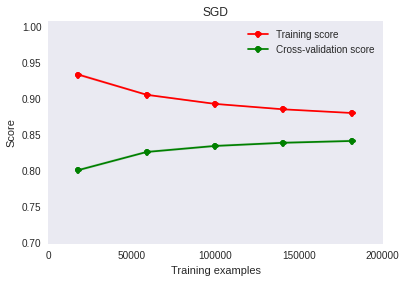

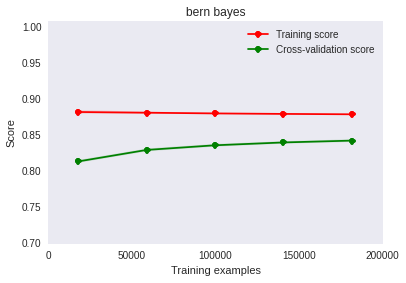

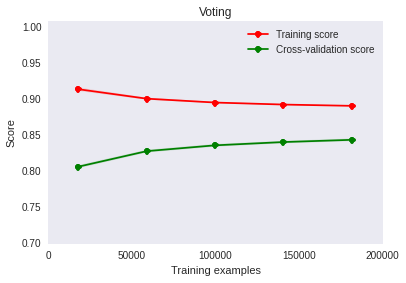

In [12]:
models_to_test = [
    ('SGD', SGDClassifier(n_iter=50, loss='modified_huber')),
    ('bern bayes', naive_bayes.BernoulliNB()),
    ('Voting', VotingClassifier(estimators= [('mult NB', naive_bayes.MultinomialNB()),
                          ('SVM', svm.LinearSVC()),
                          ('SGD', SGDClassifier(n_iter=50, loss='modified_huber')),
                          ('bern bayes', naive_bayes.BernoulliNB())              
                         ]))
    ]

learning_curves(models_to_test)

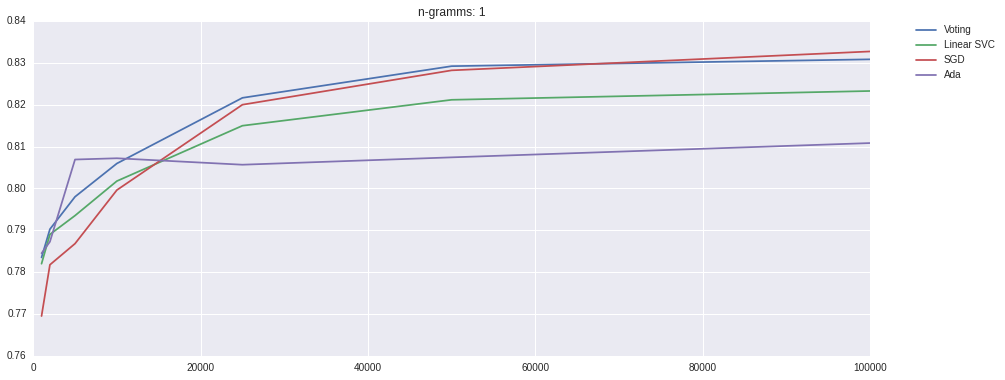

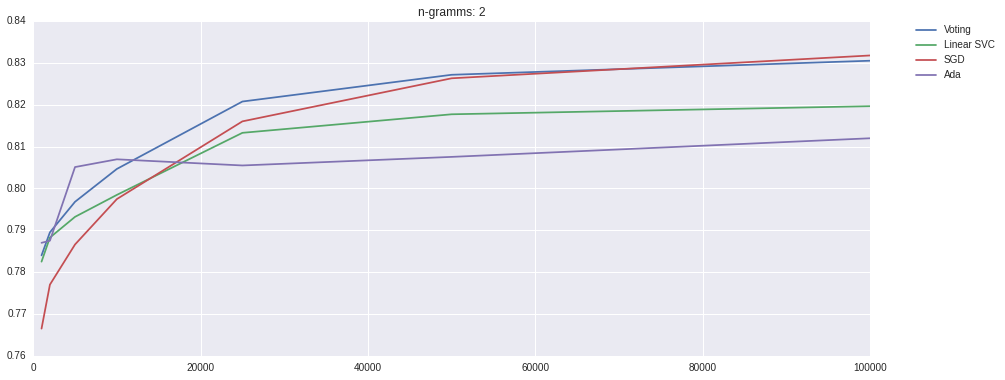

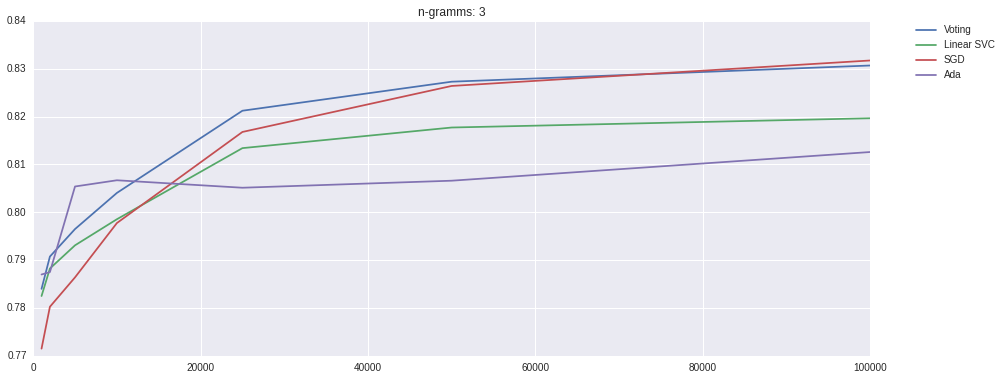

In [13]:
models_to_test = [
    #('XGB', xgb.XGBClassifier(n_estimators=1200, max_depth=5, learning_rate=0.02)), #too low accuracy
    ('Linear SVC', svm.LinearSVC()),
    #('Non-linear SVC', svm.SVC(gamma=0.1)), #takes too long time to compute
    ('SGD', SGDClassifier(n_iter=50, loss='modified_huber')),
    #('Ada', AdaBoostClassifier(SGDClassifier(n_iter=50, loss='modified_huber'))),
    #('KNC', KNeighborsClassifier()), #consume too much RAM
    ('Voting', VotingClassifier(estimators= [('XGB', xgb.XGBClassifier(n_estimators=1200, max_depth=5, learning_rate=0.02)),
                              ('SVM', svm.LinearSVC()),
                              ('SGD', SGDClassifier(n_iter=50, loss='modified_huber')),
                              ('Ada', AdaBoostClassifier(SGDClassifier(n_iter=50, loss='modified_huber')))              
                             ]))
    ]

# В оригинальном датасете около 111.000 сообщений каждого класса. 
# Слишком долго работать со всеми при прототипировании
sizes_to_test = [1000, 2000, 5000, 10000, 25000]

scores = test_models(sizes_to_test, models_to_test, delta_idf = True, n_gramms_max = 3, max_words = 5000)

*** starting process 2000 tweets ***
scoring for 'Linear SVC' completed in: 0.01 min
scoring for 'SGD' completed in: 0.01 min
scoring for 'bern bayes' completed in: 0.01 min
scoring for 'Voting' completed in: 0.01 min
*** starting process 4000 tweets ***
scoring for 'Linear SVC' completed in: 0.01 min
scoring for 'SGD' completed in: 0.01 min
scoring for 'bern bayes' completed in: 0.01 min
scoring for 'Voting' completed in: 0.01 min
*** starting process 10000 tweets ***
scoring for 'Linear SVC' completed in: 0.03 min
scoring for 'SGD' completed in: 0.03 min
scoring for 'bern bayes' completed in: 0.02 min
scoring for 'Voting' completed in: 0.03 min
*** starting process 20000 tweets ***
scoring for 'Linear SVC' completed in: 0.04 min
scoring for 'SGD' completed in: 0.05 min
scoring for 'bern bayes' completed in: 0.04 min
scoring for 'Voting' completed in: 0.05 min
*** starting process 50000 tweets ***
scoring for 'Linear SVC' completed in: 0.1 min
scoring for 'SGD' completed in: 0.11 min


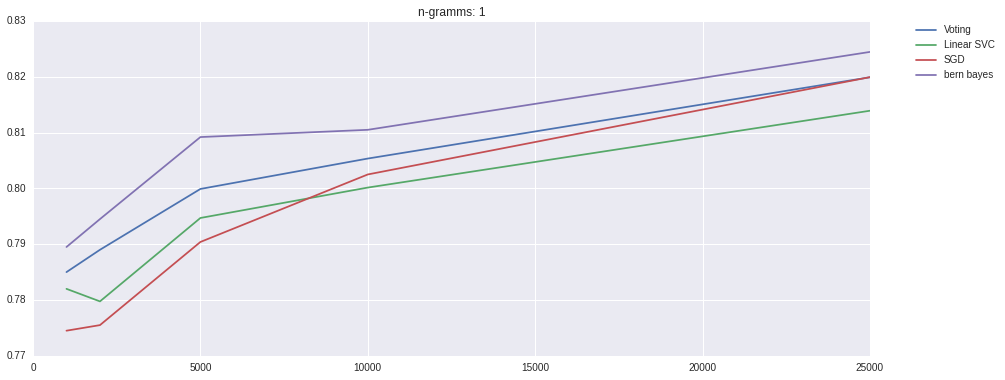

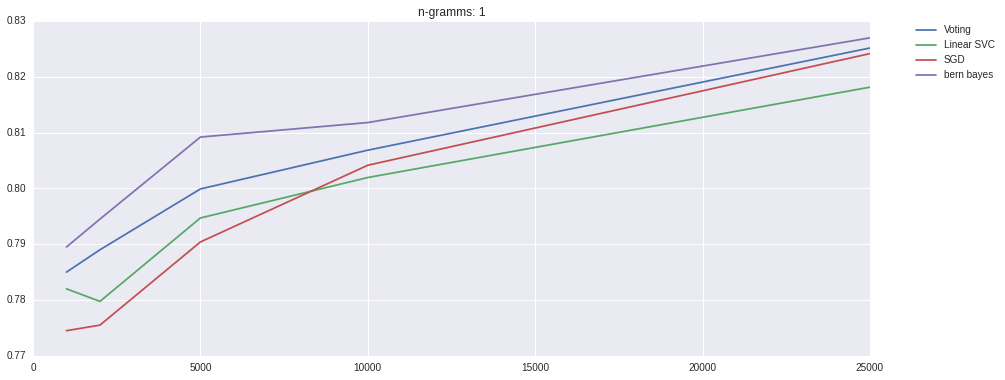

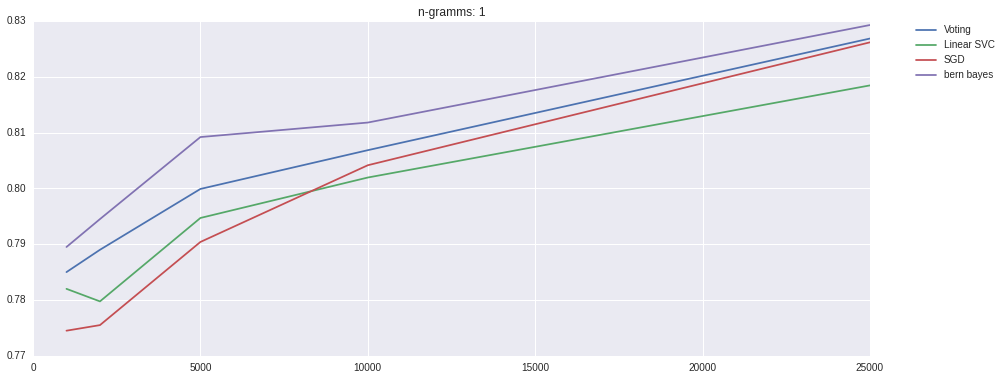

In [28]:
models_to_test = [
    #('mult bayes', naive_bayes.MultinomialNB()),
    #('XGB', xgb.XGBClassifier(n_estimators=1200, max_depth=5, learning_rate=0.02)), #too low accuracy
    ('Linear SVC', svm.LinearSVC()),
    #('Non-linear SVC', svm.SVC(gamma=0.1)), #takes too long time to compute 
    ('SGD', SGDClassifier(n_iter=50, loss='modified_huber')),
    ('bern bayes', naive_bayes.BernoulliNB()),
    #('Ada', AdaBoostClassifier(SGDClassifier(n_iter=50, loss='modified_huber'))),
    ('Voting', VotingClassifier(estimators= [('mult NB', naive_bayes.MultinomialNB()),
                          ('SVM', svm.LinearSVC()),
                          ('SGD', SGDClassifier(n_iter=50, loss='modified_huber')),
                          ('bern bayes', naive_bayes.BernoulliNB())              
                         ]))

]

# В оригинальном датасете около 111.000 сообщений каждого класса. 
# Слишком долго работать со всеми при прототипировании
sizes_to_test = [1000, 2000, 5000, 10000, 25000]

scores = test_models(sizes_to_test, models_to_test, delta_idf = False, max_words=[5000, 10000, None], debug_lvl=2)

## Веса
Веса н-грамм при использовании delta tf-idf векторизации.

In [7]:
X = pd.concat([pos, neg], ignore_index=True)

X_tweets = X['ttext'].apply(remove_retweet)
y = X['ttype']

vectorizer = DeltaTfidfVectorizer(min_df = 3, ngram_range = (1, 3),
                          stop_words = stops, tokenizer = tweet_tokenize)

vectorizer.fit(X_tweets, y)

scores = vectorizer.weight_of_words(is_sorted = True)

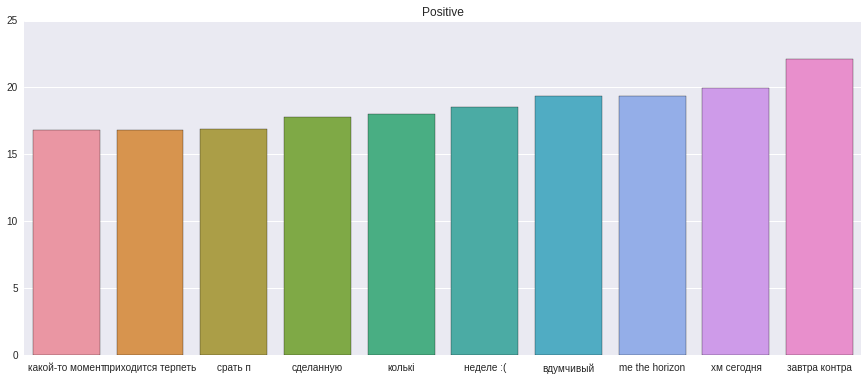

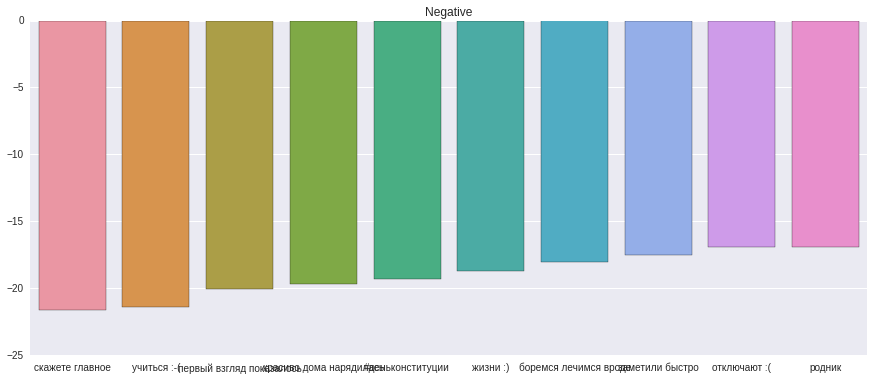

In [8]:
plt.figure(figsize=FIG_SIZE)
sns.barplot(x=[w[0] for w in scores[-10:]], y=[w[1] for w in scores[-10:]])
sns.plt.title('Positive')

plt.figure(figsize=FIG_SIZE)
sns.barplot(x=[w[0] for w in scores[:10]], y=[w[1] for w in scores[:10]])
sns.plt.title('Negative')

## Веса
Частота появления определенных токенов в позитивных и негативных твитах

In [9]:
X_tweets = list(pos['ttext'])

words = list()

for s in X_tweets:
    words += remove_stop_words(tweet_tokenize(s))

words_counts = Counter(words)
words_counts = sorted([(w, words_counts[w]) for w in words_counts], key=lambda x: x[1])

pos_words = words_counts[-15:]

X_tweets = list(neg['ttext'])

words = list()

for s in X_tweets:
    words += remove_stop_words(tweet_tokenize(s))

words_counts = Counter(words)
words_counts = sorted([(w, words_counts[w]) for w in words_counts], key=lambda x: x[1])

neg_words = words_counts[-15:]

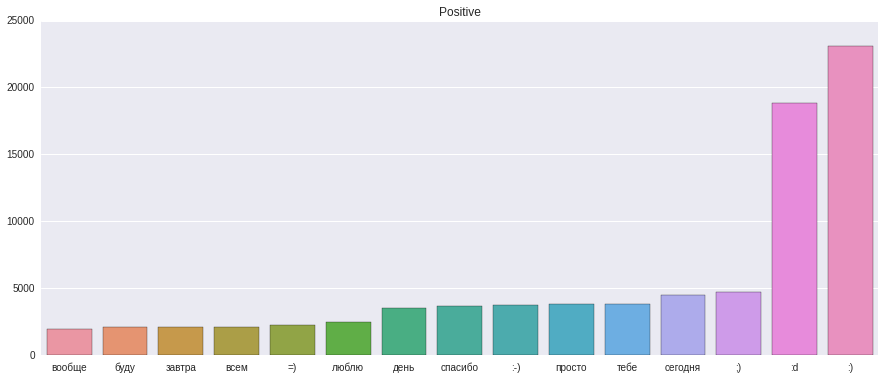

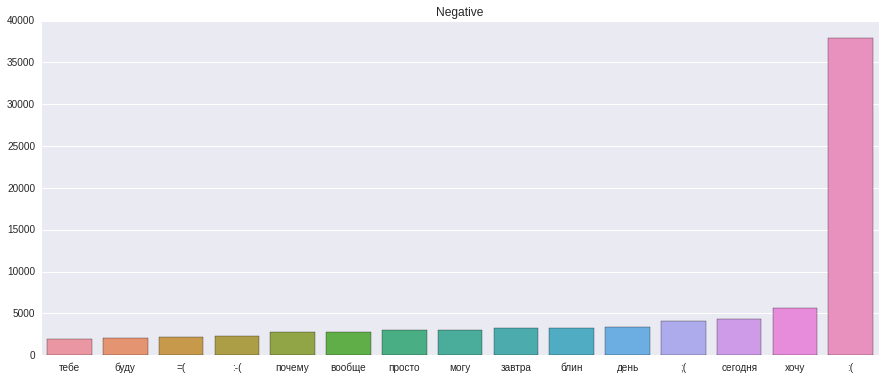

In [10]:
plt.figure(figsize=FIG_SIZE)
sns.barplot(x=[w[0] for w in pos_words], y=[w[1] for w in pos_words])
sns.plt.title('Positive')

plt.figure(figsize=FIG_SIZE)
sns.barplot(x=[w[0] for w in neg_words], y=[w[1] for w in neg_words])
sns.plt.title('Negative')

## Зависимость между днем и тональностью
Проверяется гипотеза, влияет ли день недели и время суток на тональность твита (например, утром твиты негативнее, а вечером позитивнее).
Проверить влияние времени года на тональность нельзя т.к. в данных представлены твиты только за декабрь и январь.
Видно, что зависимость есть (в пятницу очень мало позитивных твитов, но их больше с пон. по четверг), но тесты показали, что такой подход не работает (мало данных?)

In [12]:
neg = pd.read_csv('data/train/negative.csv', sep=';')
pos = pd.read_csv('data/train/positive.csv', sep=';')

neg = neg.drop(['id', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos = pos.drop(['id', 'trep', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos['ttext'] = pos['ttext'].apply(remove_retweet)
neg['ttext'] = neg['ttext'].apply(remove_retweet)

In [13]:
def convert_date(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp)
    h = date.hour
    
#     if h <= 6:
#         d_type = 'Night'
#     elif h <= 12:
#         d_type = 'Morning'
#     elif h <= 18:
#         d_type = 'Midday'
#     else:
#         d_type = 'Evening'
    
    if h >= 23 or h <= 5:
        d_type = 'Night'
    elif h > 5 and h <= 11:
        d_type = 'Morning'
    elif h > 11 and h <= 18:
        d_type = 'Midday'
    else:
        d_type = 'Evening'
    
    return pd.Series({'Weekday':date.strftime('%A'), 'DayPart': d_type})

def rename_type(num):
    if num == -1:
        return 'neg'
    else:
        return 'pos'

In [1679]:
neg_date = neg['tdate'].apply(convert_date)
pos_date = pos['tdate'].apply(convert_date)
X = pd.concat([neg, pos])
X = pd.concat([X, pd.concat([neg_date, pos_date])], axis=1)

X['ttype'] = X['ttype'].apply(rename_type)

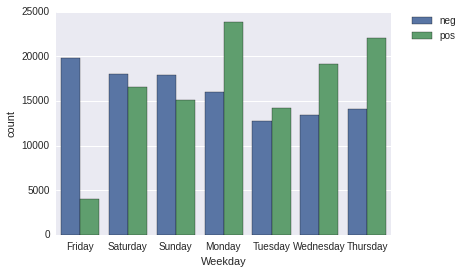

In [1690]:
sns.countplot(x='Weekday', data=X, hue='ttype')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

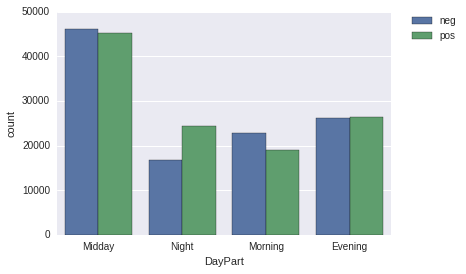

In [1691]:
sns.countplot(x='DayPart', data=X, hue='ttype')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Зависимость между тональностью и параметрами пользователей
Проверяется зависимость между типом твита и то, насколько пользователь часто пишет, сколько у него подписчиков и т.п. Была выдвинута гипотеза, что такая зависимость может быть поскольку некоторые пользователи склонные к негативным сообщениям, а некоторые наоборот, следовательно, более негативные/позитивные пользователи могут пользоваться бОльшей или меньшей популярностью, следовательно, исходя из параметров пользователя можно предсказать тональность твита.

Заметной корреляции обнаружено не было, поэтому данные свойства не используются в анализе.

In [212]:
neg = pd.read_csv('data/train/negative.csv', sep=';')
pos = pd.read_csv('data/train/positive.csv', sep=';')

neg = neg.drop(['Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'id', 'trep'], axis=1)

pos = pos.drop(['Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'id', 'trep'], axis=1)

X = pd.concat([pos, neg])

In [213]:
X.select_dtypes(include=['float', 'int64']).columns.values

array(['tdate', 'ttype', 'trtw', 'tfav', 'tstcount', 'tfrien', 'listcount'], dtype=object)

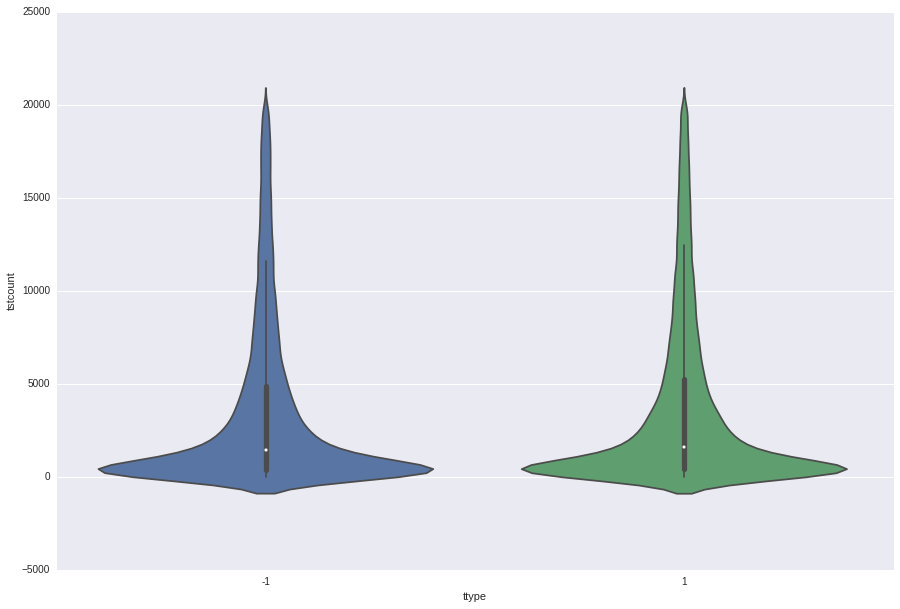

In [214]:
# Зависимости между тоном твитов и числом твитов пользователя нет
plt.figure(figsize=(15, 10))
sns.violinplot(x='ttype', y='tstcount', data=X.loc[X['tstcount'] < 20000])

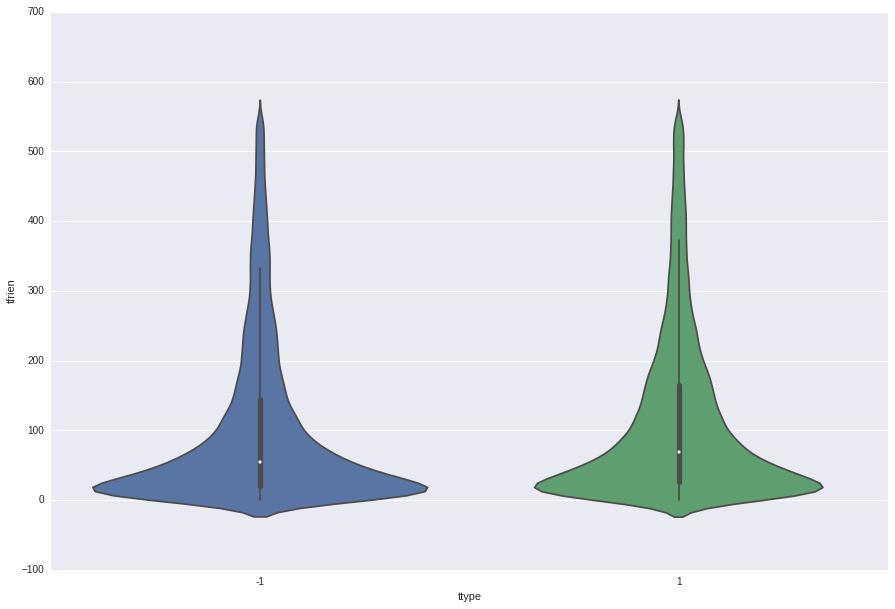

In [215]:
# У людей, которые пишут позитивные твиты, больше друзей? Небольшая корреляция есть (вроде)
plt.figure(figsize=(15, 10))
sns.violinplot(x='ttype', y='tfrien', data=X.loc[X['tfrien'] < 550])

In [128]:
pos['tfrien'].describe()

count     114910.000000
mean         785.609799
std        10790.510490
min            0.000000
25%           32.000000
50%           97.000000
75%          282.000000
max      1582807.000000
Name: tfrien, dtype: float64

In [129]:
neg['tfrien'].describe()

count     111922.000000
mean         565.517941
std         8583.052619
min            0.000000
25%           23.000000
50%           71.000000
75%          237.000000
max      1236196.000000
Name: tfrien, dtype: float64

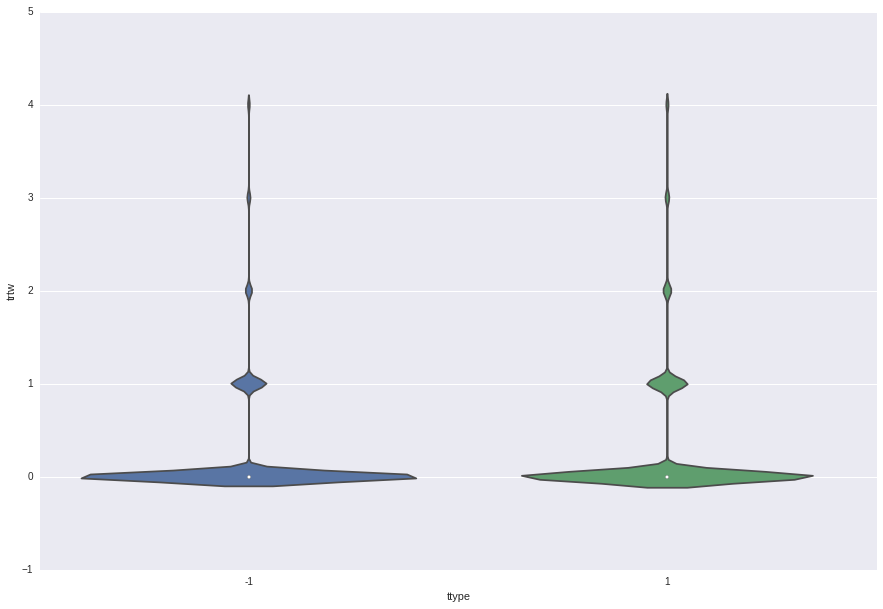

In [134]:
# Позитивные и негативные посты ретвитят примерно одинаково
plt.figure(figsize=(15, 10))
sns.violinplot(x='ttype', y='trtw', data=X.loc[X['trtw'] < 5])

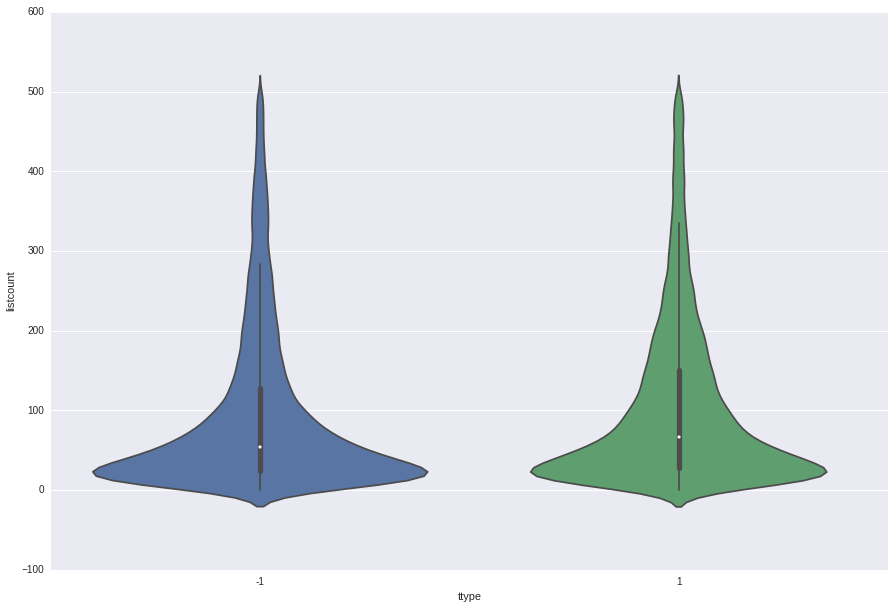

In [145]:
# Люди с позитивными постами чаще попадают в подписки
plt.figure(figsize=(15, 10))
sns.violinplot(x='ttype', y='listcount', data=X.loc[X['listcount'] < 500])

@Joan_Mady мужик молодец ! Грамотно и красиво пишет, ведь, как-никак, МГУ закончил :D
иду встречаться с одноклассником, который закончил экономику в МГУ и работает по специальности))
Ох, только вернулась)
Встретила Влада в метро, говорит в МГУ - одна студенческая жизнь хД, никакой учебы! 
RT @malakhowskiy: Большинству петербургских студентов не нужны секс и деньги. Это вам не студенты МГУ)
Два фигуранта дела "Оборонсервиса" попросили об амнистии. И, готова поспорить, их и амнистируют! А вот студентов МГУ - нет((
сегодня женщина из КЕМГУ говорила про субкультуры, типа мажоры, по словам Марка получается я неформал(
